# Studying regression with linear and ensembling models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Data prep
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin  # building custom transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.model_selection import learning_curve, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib  # saving model to pickle
import eli5

In [2]:
# Some common settings
sns.set()
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

In [3]:
# Some common variables
PATH_DATA = "./datasets"

In [156]:
# Custom functions
def plot_distribution(x):
    """
    Plot a histogram and QQ plot of x
    """
    fig, axs = plt.subplots(1, 2)

    x.hist(ax=axs[0])
    scipy.stats.probplot(x, plot=plt)
    plt.show()
    
def plot_fi(features, scores, aspect=2):
    """
    Return a dataframe {
    'feature': features,
    'score': scores
    }
    and plot a bar chart showing features with score greater or equal than 1 SD
    """
    df = pd.DataFrame({
        'feature': features,
        'score': scores
    })

    # >= 1 SD
    data = df[np.abs(df['score']) >= np.std(df['score'])]

    # Bar chart
    sns.catplot(x='score', y='feature',
                data=data.sort_values('score', ascending=False), kind='bar', aspect=2)

    return df

# Get the dataset

In [4]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {PATH_DATA}

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -n {PATH_DATA}/house-prices-advanced-regression-techniques.zip -d {PATH_DATA}

Archive:  ./datasets/house-prices-advanced-regression-techniques.zip


In [6]:
df_train_raw = pd.read_csv(f'{PATH_DATA}/train.csv')
df_test_raw = pd.read_csv(f'{PATH_DATA}/test.csv')

In [7]:
print(df_train_raw.shape, df_test_raw.shape)

(1460, 81) (1459, 80)


## Correct the data types

In [8]:
# Make a copy to avoid modifying the original dataset
df = df_train_raw.copy()

# Make the Id column as index
df.set_index('Id', inplace=True)

### Numerical type

In [9]:
# Display only numerical type
df.select_dtypes('number').head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [10]:
# Columns which should be categorical
cols = ['MSSubClass', 'OverallQual', 'OverallCond']

# Keep track of the numerical columns
num_cols = list(df.select_dtypes('number').columns)
num_cols.remove('MSSubClass')
num_cols.remove('OverallQual')
num_cols.remove('OverallCond')

In [11]:
# Number of numerical features
len(num_cols)

34

### Categorical type

In [12]:
# Display all non-numerical type
df.select_dtypes('object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [13]:
### Columns which are categorical
cat_cols = list(df.select_dtypes('object').columns)
# Add the 3 categorical columns identified earlier in the numerical section
for col in cols:
    cat_cols.append(col)
    
### Ordering ordinal features which may help our EDA
# columns with 1-10 ratings
cond_cols = ['OverallQual', 'OverallCond']
cat_condition = pd.api.types.CategoricalDtype(ordered=True)
# columns with a 5-grade rating
grade5_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', \
               'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
cat_grade5 = pd.api.types.CategoricalDtype(categories=['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], ordered=True)

In [14]:
# Number of categorical features
len(cat_cols)

46

### Data type conversion

In [15]:
df[cat_cols] = df[cat_cols].astype('category')
df[cond_cols] = df[cond_cols].astype(cat_condition)
df[grade5_cols] = df[grade5_cols].astype(cat_grade5)

# EDA

<hr>

**Summary:** The housing dataset contains 1460 records of past housing sales, with 34 numerical features and 46 categorical features. From the EDA process below, there are a few observations:

* The dependent variable `SalePrice` is right skewed. We'll perform a log transformation.
* Some independent variables are not in the perfect shape. Some of them are skewed, some of them have multicollinearity, and some of them shows heteroscedasticity. We will try to apply log transformation to some of them and fix the skewness. Note that this is required for linear models but not necessary for Random Forest and Gradient Boosting Regression Tree (GBRT).
* Outliers can be found in variables like `GrLivArea`, `1stFlrSF`, `TotalBsmtSF`. We will remove those records in our training set preparation.

As for missing values, there are a 5 columns with >47% missing values, and we will drop those features. Other than that, we will also drop `Utilities` and then rely on models to do feature selection (e.g., Lasso, Elastic Net, Random Forest and GBRT). For numerical features, we will impute from the median. For categorical features, we will fill with 'NA'. Note that there are unseen category (i.e., columns with missing values in the test set but not in training set), and we will ignore them in the test set's one hot encoding to make the model generalize better to unseen data.

Lastly, we have some success in creating new feature out from those year-related and area-related variables. `Year_built_to_sold`, `Year_remod_to_sold`, `Year_garageblt_to_sold`, `TotalArea` all have quite a good correlation with the SalePrice.

<hr>

In [16]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0


## Distribution

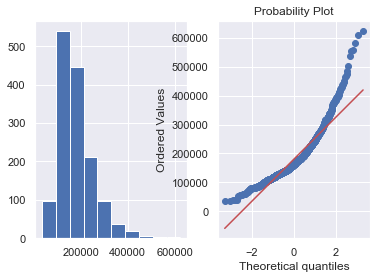

In [105]:
# Check the dependent variable distribution
plot_distribution(df['SalePrice'])

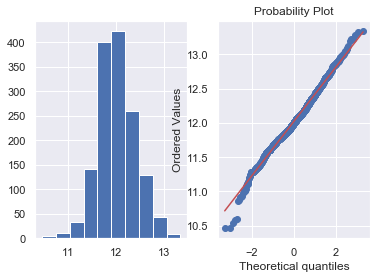

In [106]:
# The dependent variable's distribution after log transformation
plot_distribution(np.log1p(df['SalePrice']))

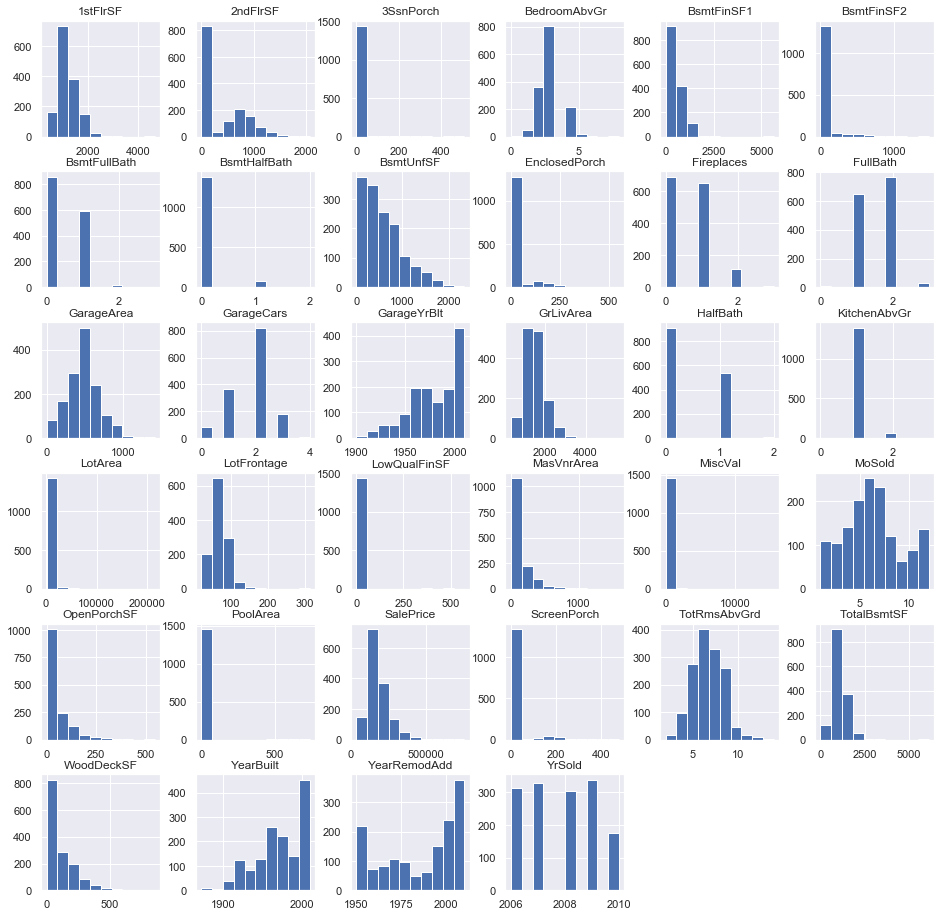

In [19]:
# The independent variables distribution
df[num_cols].hist(figsize=(16, 16))
plt.show()

> There are year-related features (i.e., `GarageYrBlt`, `YearBuilt`, `YearRemodAd`, `YrSold`) do not fit as numerical values. We are going to create new features out of these.

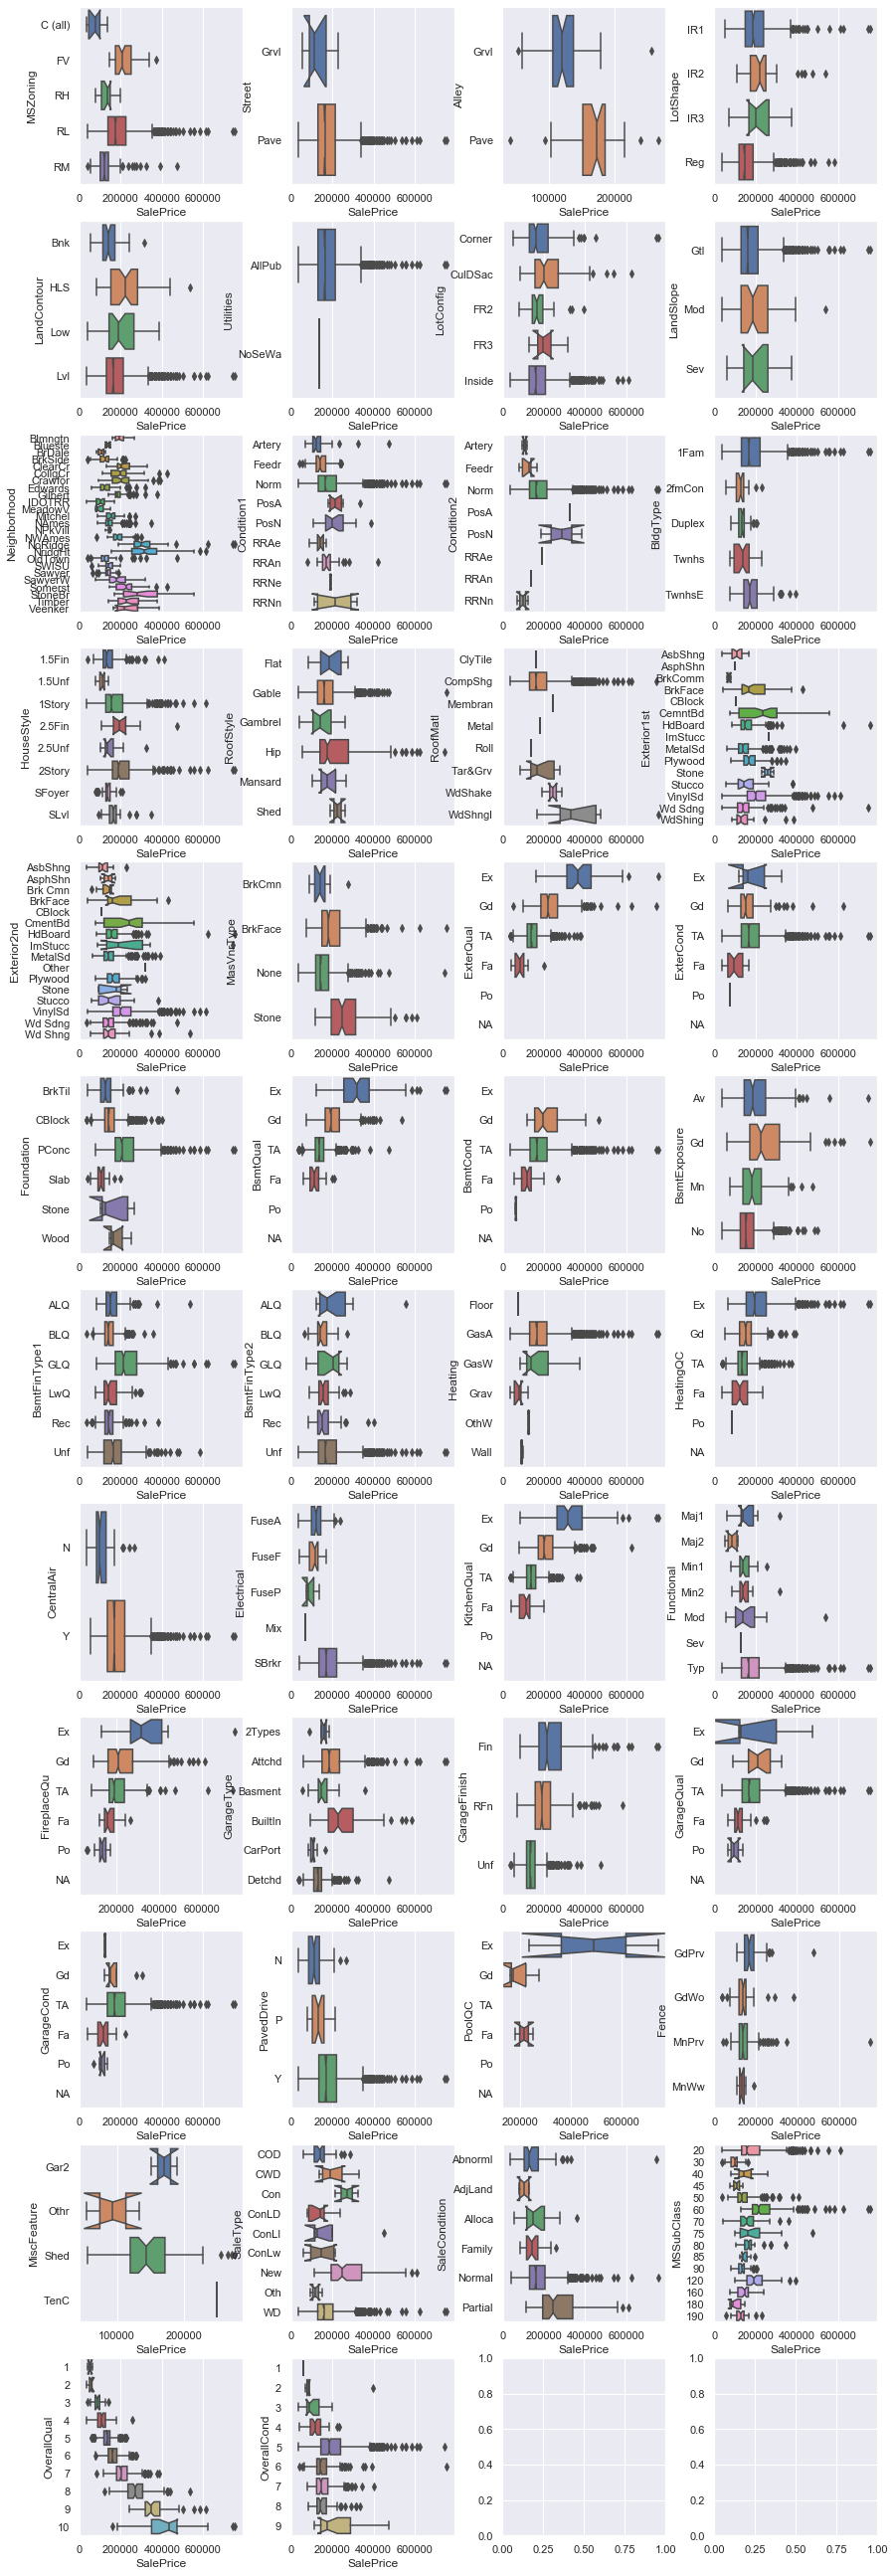

In [20]:
# Check the independent variables (categorical) distributions
fig, axes = plt.subplots(12, 4, figsize=(12, 36))
fig.tight_layout()
axes = axes.reshape(-1)
# Plot
for i, col in enumerate(cat_cols):
    sns.boxplot(x='SalePrice', y=col, data=df, ax=axes[i], notch=True)

In [21]:
# Utilities column is useless
df['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

> There are some good categorical features, specifically those 'quality' features for overall, fireplace, kitchen, etc.. We will work on one hot encoding so that our regression models can make use of these. On the other hand, the feature `Utilities` is basically useless and we'll drop it.

## Missing data

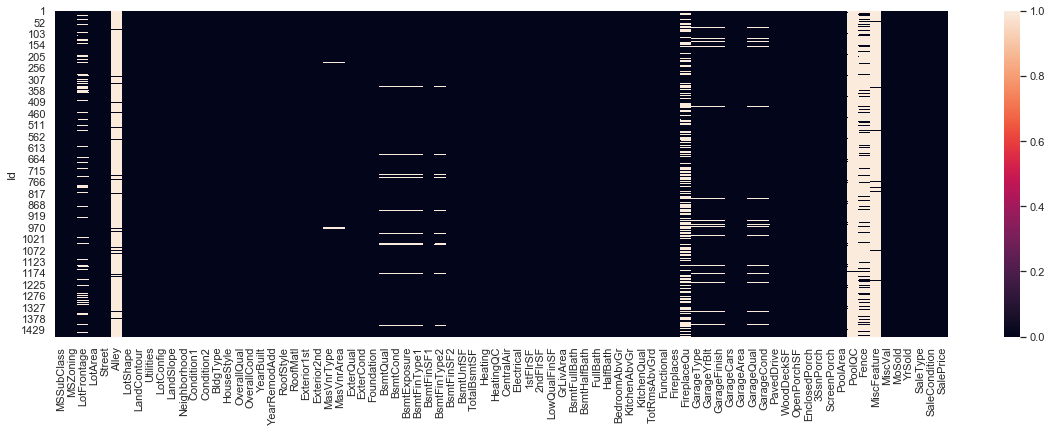

In [22]:
# Generate a heatmap showing where the missing values are
plt.figure(figsize=(20, 6))
sns.heatmap(df.isna())

In [23]:
# Missing values with raio > .2 in training data
# Safely drop these
train_missing = (df.isna().sum()/len(df)).sort_values(ascending=False)
train_missing = train_missing[train_missing > 0.2]
train_missing

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
dtype: float64

## Correlation

In [24]:
# Correlation with the dependent variable
corr = df.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

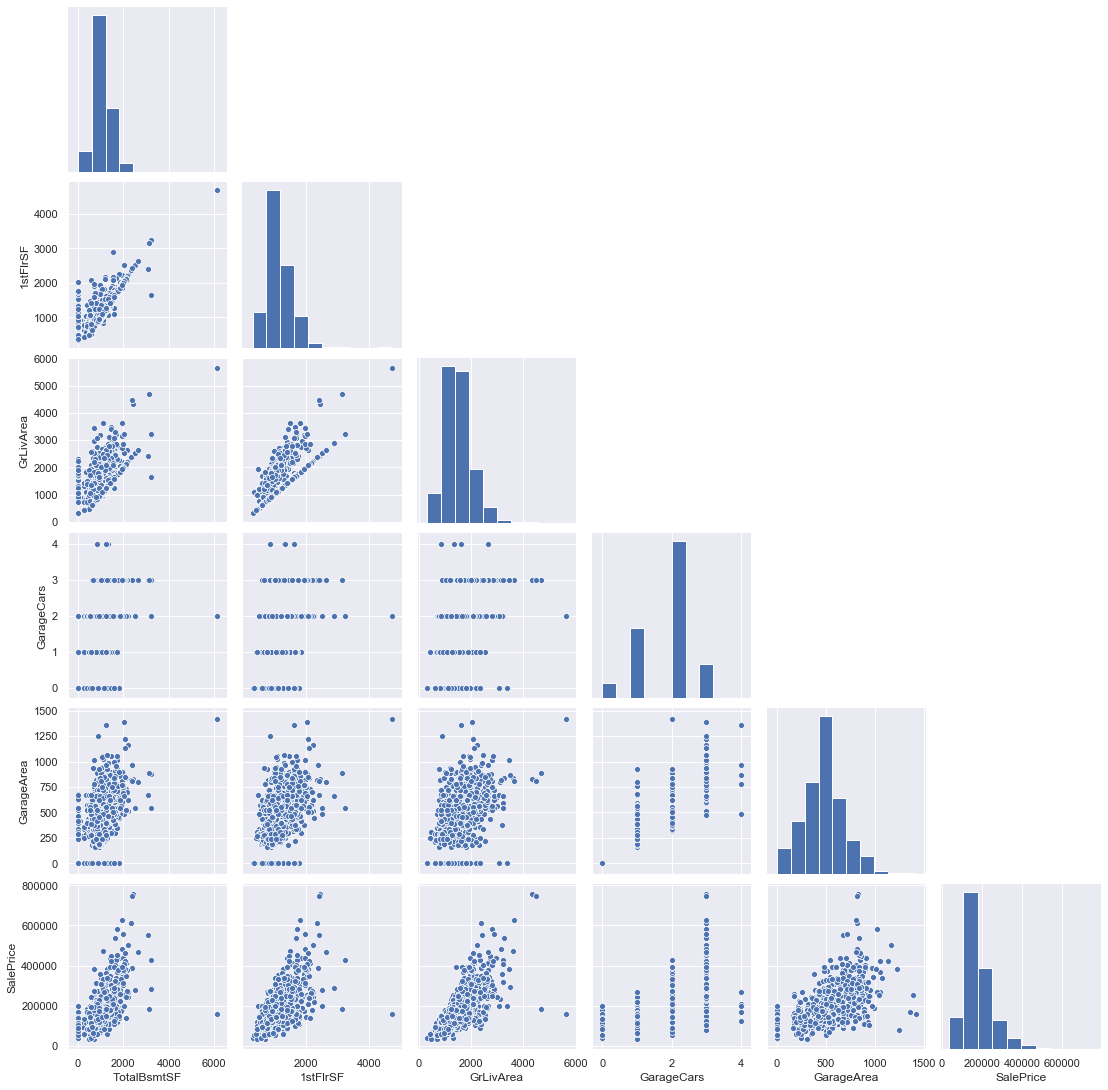

In [25]:
# Pairplot for those features with correlation >.6
sns.pairplot(df[corr[corr['SalePrice'] > .6].index], corner=True)

> There are some strange patterns, and we'll leave those alone at the moment.
* `1stFlrSF` vs `TotalBsmtSF`: There's a diagonal line showing 1st floor area = basement area.
* `GrLivArea` vs `TotalBsmtSF`: Again there's a diagonal line showing above ground area = basement area.

## Experiment: Features engineering

In [26]:
# Year from built to sold
df["Year_built_to_sold"] = np.maximum(df["YrSold"] - df["YearBuilt"], 0)
df.drop('YearBuilt', axis=1, inplace=True)

# Year from remod to sold
df["Year_remod_to_sold"] = np.maximum(df["YrSold"] - df["YearRemodAdd"], 0)
df.drop('YearRemodAdd', axis=1, inplace=True)

# Year from garage built to sold
df["Year_garageblt_to_sold"] = np.maximum(df["YrSold"] - df["GarageYrBlt"], 0)

# Drop remaining year columns
df.drop('YrSold', axis=1, inplace=True)

# Total area: basement + above ground
df["TotalArea"] = df["TotalBsmtSF"] + df["GrLivArea"]

In [27]:
# Check how the new features are performing
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice                 1.000000
TotalArea                 0.778959
GrLivArea                 0.708624
GarageCars                0.640409
GarageArea                0.623431
TotalBsmtSF               0.613581
1stFlrSF                  0.605852
FullBath                  0.560664
TotRmsAbvGrd              0.533723
GarageYrBlt               0.486362
MasVnrArea                0.477493
Fireplaces                0.466929
BsmtFinSF1                0.386420
LotFrontage               0.351799
WoodDeckSF                0.324413
2ndFlrSF                  0.319334
OpenPorchSF               0.315856
HalfBath                  0.284108
LotArea                   0.263843
BsmtFullBath              0.227122
BsmtUnfSF                 0.214479
BedroomAbvGr              0.168213
ScreenPorch               0.111447
PoolArea                  0.092404
MoSold                    0.046432
3SsnPorch                 0.044584
BsmtFinSF2               -0.011378
BsmtHalfBath             -0.016844
MiscVal             

# Data preparation

<hr>

**Summary:** We have built a pipeline for numerical features:
* impute with median
* features engineering with a custom transformer. And apply log transformation to the total area.
* standard scaling

And a separate pipeline for categorical features:
* fill missing values with 'NA'
* drop unwanted features
* one hot encoding, which ignores unseen category (appears only in test set but not training set)

Finally combine the two pipelines with a ColumnTransformer, so that we can easily fit and/or transform our datasets in just one line.

<hr>

## Custom transformer: Features creation

In [28]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    A custom transformer (for sklearn pipeline) to create additional numerical features.
    Put it after imputers in the pipeline as this does not handle df > array.
    """
    def __init__(self):
        self.YrSold = 32
        self.YearBuilt = 2
        self.YearRemodAdd = 3
        self.GarageYrBlt = 21
        self.TotalBsmtSF = 8
        self.GrLivArea = 12

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        # year related
        year_built_to_sold = np.maximum(X[:, self.YrSold] - X[:, self.YearBuilt], 0)
        year_remod_to_sold = np.maximum(X[:, self.YrSold] - X[:, self.YearRemodAdd], 0)
        year_garageblt_to_sold = np.maximum(X[:, self.YrSold] - X[:, self.GarageYrBlt], 0)
        # area related
        total_area = X[:, self.TotalBsmtSF] + X[:, self.GrLivArea]
        total_area = np.log1p(total_area)  # a good target of log transformation
        # drop the columns
        X = np.delete(X, [self.YrSold, self.YearBuilt, self.YearRemodAdd, self.GarageYrBlt], 1)
        return np.c_[X, year_built_to_sold, year_remod_to_sold, year_garageblt_to_sold, total_area]

In [29]:
class DropAttributes(BaseEstimator, TransformerMixin):
    """
    A custom transformer (for sklean pipeline) to remove unwanted categorical features.
    Put it after imputers in the pipeline as this does not handle df > array.
    """
    def __init__(self):
        self.PoolQC = 38
        self.MiscFeature = 40
        self.Alley = 2
        self.Fence = 39
        self.FireplaceQu = 32
        self.Utilities = 5
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        # drop the columns
        X = np.delete(X, [self.PoolQC,
                          self.MiscFeature,
                          self.Alley,
                          self.Fence,
                          self.FireplaceQu,
                          self.Utilities], 1)
        return X

## Building the transformation pipeline

### Numerical pipeline

In [30]:
# The numerical pipeline
num_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy="median")),
    ('attr_adder', AttributesAdder()),
    ('std_scaler', StandardScaler())
])

### Categorical pipeline

In [31]:
# The categorical pipeline
cat_pipeline = Pipeline([
    ('na_imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('drop_attr', DropAttributes()),
    # For categories unseen in fitting, the resulting one-hot encoded columns
    # for this feature will be all zeros
    ('ohe', OneHotEncoder(handle_unknown='ignore'))  
])

### Combining the two

In [32]:
num_cols = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
cat_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond']
print(len(num_cols), len(cat_cols))  # sum = 79

33 46


In [33]:
# The full pipeline
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ])

### Transform the training set and test set

In [34]:
# Dropping some outliers after the study of feature importance
df = df_train_raw[df_train_raw['GrLivArea'] < 4000]

In [35]:
df.set_index('Id').drop('SalePrice', axis=1).describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1456.000000,1197.000000,1456.000000,1456.000000,1456.000000,1456.00000,1456.000000,1448.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1375.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,56.888736,69.693400,10448.784341,6.088599,5.576236,1971.18544,1984.819368,102.087707,436.991071,46.677198,566.990385,1050.658654,1157.108516,343.532967,5.860577,1506.502060,0.423764,0.057005,1.561813,0.381181,2.864698,1.046703,6.506181,0.609203,1978.440000,1.764423,471.568681,93.833791,46.221154,22.014423,3.418956,15.102335,2.055632,43.608516,6.326236,2007.817308
std,42.358363,23.054474,9860.763449,1.369669,1.113966,30.20159,20.652143,177.338930,430.255052,161.522376,442.197182,412.155715,369.307331,431.528915,48.688904,496.815378,0.517420,0.237786,0.547683,0.502533,0.815800,0.220627,1.611800,0.640359,24.692738,0.746215,211.986421,125.192349,65.352424,61.192248,29.357056,55.828405,35.383772,496.799265,2.698356,1.329394
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.00000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7538.750000,5.000000,5.000000,1954.00000,1966.750000,0.000000,0.000000,0.000000,222.500000,795.000000,882.000000,0.000000,0.000000,1128.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,329.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9468.500000,6.000000,5.000000,1972.00000,1993.500000,0.000000,381.000000,0.000000,477.500000,990.500000,1086.000000,0.000000,0.000000,1458.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,478.500000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11588.000000,7.000000,6.000000,2000.00000,2004.000000,164.250000,706.500000,0.000000,808.000000,1293.750000,1389.250000,728.000000,0.000000,1775.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.00000,2010.000000,1600.000000,2188.000000,1474.000000,2336.000000,3206.000000,3228.000000,1818.000000,572.000000,3627.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [36]:
# The well-prepared training set
X_train = full_pipeline.fit_transform(
    df.set_index('Id').drop('SalePrice', axis=1)
)

In [37]:
# The dependent variable. Log transform it as observed in the EDA process
y = np.array(np.log1p(df['SalePrice']))

In [38]:
# The well-prepared test set
X_test = full_pipeline.transform(df_test_raw.set_index('Id'))  # do not "fit" with test set

In [39]:
print(X_train.shape, y.shape, X_test.shape)  # equal number of columns

(1456, 309) (1456,) (1459, 309)


In [40]:
# Get back the feature names after the numerical pipeline
final_num_cols = num_cols.copy()
final_num_cols.remove('YrSold')
final_num_cols.remove('YearBuilt')
final_num_cols.remove('YearRemodAdd')
final_num_cols.remove('GarageYrBlt')
final_num_cols.append('year_built_to_sold')
final_num_cols.append('year_remod_to_sold')
final_num_cols.append('year_garageblt_to_sold')
final_num_cols.append('total_area')

# Get back the feature names after one hot encoding
final_cat_cols = cat_cols.copy()
final_cat_cols.remove('PoolQC')
final_cat_cols.remove('MiscFeature')
final_cat_cols.remove('Alley')
final_cat_cols.remove('Fence')
final_cat_cols.remove('FireplaceQu')
final_cat_cols.remove('Utilities')
final_features_cat = full_pipeline.named_transformers_.cat.named_steps.ohe.get_feature_names(final_cat_cols)
final_features = np.concatenate((final_num_cols, final_features_cat))

# Modeling

<hr>

**Summary:** First of all, predicting the housing sales price is a problem for supervised learning. We have the real value `SalePrice` and 309 features after the preparation pipeline in the previous section. As this is not a big dataset, it does not make any difference whether we employ online or batch learning methods.

In the first part I'll be using a few linear models, which are usually fast to train and predict. However these models have a few assumptions on the independent variables which require careful date preparation: a) normality, b) little or no multicollinearity, c) homoscedasticity. 

Ordinary least squares (OLS) is definitely going to overfit so I will start with L2 regularization (i.e., Ridge regression) as a baseline. This method will try to set the coefficients of features as small as possible, which can generalize better than OLS. Depends on the result, we may try with Lasso regression, which will perform feature selection (i.e., set the coefficients of unimportant features to zero), or a mix of both using Elastic Net.

In the second part I'll be using ensembling models: Random Forest and GBRT. These models are transformation invariant, so the data preparation pipeline for linear models can be shared here. Note that the dependent variable `y` is log transformed to have better normality, which may sometimes make the models perform better.

<hr>

In [41]:
def print_grid_search_result(gs, coef=True):
    """
    Print out
    * best hyperparameter set
    * best CV score
    * number of features of coef > 0 (if any)
    """
    print('Best hyperparameter set: ', gs.best_params_)
    print('Best RMSE on CV: ', np.sqrt(-gs.best_score_))
    if coef:
        print('Number of features: ', np.array(grid_search.best_estimator_.coef_ != 0).sum())

In [42]:
def train_and_evaluate(X, y, model, scoring='neg_mean_squared_error'):
    """
    To prepare a df for plotting learning curve.
    """
    train_sizes, train_scores, cv_scores = learning_curve(
                                               model, X, y,
                                               scoring=scoring,
                                               cv=KFold(n_splits=10, shuffle=True, random_state=42),
                                               n_jobs=-1
                                           )
    # Averages scores of the K-Fold CV
    train_scores = train_scores.mean(1)
    cv_scores = cv_scores.mean(1)
    
    # Prepare RMSE
    if scoring == 'neg_mean_squared_error':
        train_scores = np.sqrt(-train_scores)
        cv_scores = np.sqrt(-cv_scores)
    
    df = pd.DataFrame({"Train Sizes": train_sizes,
                       "Train Score": train_scores,
                       "CV Score": cv_scores})
    return df

## Linear models

### Ridge regression

In [43]:
# parameter grid
param_grid = [
    {'alpha': np.logspace(-4, 4, 30)}
]

# Ridge regression with everything default
ridge_reg = Ridge(random_state=42)

# Grid search
grid_search = GridSearchCV(ridge_reg, param_grid,
                           cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [44]:
# Grid search result
print_grid_search_result(grid_search)

Best hyperparameter set:  {'alpha': 4.893900918477489}
Best RMSE on CV:  0.11251649432746919
Number of features:  309


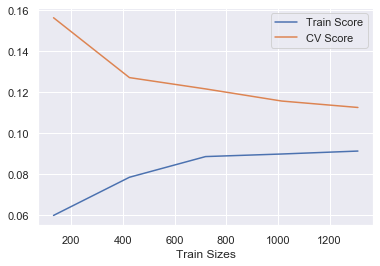

In [45]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)
res.plot.line(x=0)

> **Observations:** The Ridge regression model overfits quite a lot. Let's try to reduce some features with Lasso instead.

### Lasso

In [46]:
# parameter grid
param_grid = [
    {'alpha': np.logspace(-4, 4, 30)}
]

# Ridge regression with everything default
lasso_reg = Lasso(random_state=42, selection='random', max_iter=10_000)

# Grid search
grid_search = GridSearchCV(lasso_reg, param_grid,
                           cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='random', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-04, 1.88739182e-04, 3...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [47]:
# Grid search result
print_grid_search_result(grid_search)

Best hyperparameter set:  {'alpha': 0.0003562247890262444}
Best RMSE on CV:  0.11180269444923319
Number of features:  136


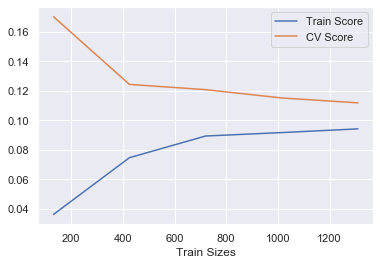

In [48]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)
res.plot.line(x=0)

> **Observations:** The Lasso regression has a lower RMSE than Ridge regression in this test, and only 135 features are left. What about a combination of both using ElasticNet?

### ElasticNet

In [49]:
# parameter grid
param_grid = [
    {'alpha': np.logspace(-4, 4, 30),
     'l1_ratio': [.1, .25, .5, .75, .9]}
]


# Ridge regression with everything default
elastic_net = ElasticNet(random_state=42, selection='random', max_iter=10_000)

# Grid search
grid_search = GridSearchCV(elastic_net, param_grid,
                           cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=10000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=42, selection='random',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-0...
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                          'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_e

In [50]:
# Grid search result
print_grid_search_result(grid_search)

Best hyperparameter set:  {'alpha': 0.0003562247890262444, 'l1_ratio': 0.75}
Best RMSE on CV:  0.11152949683701484
Number of features:  150


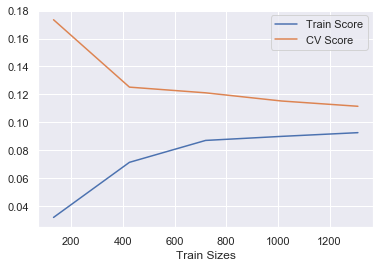

In [51]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)
res.plot.line(x=0)

In [52]:
# Saving the model
joblib.dump(grid_search.best_estimator_, f'{PATH_DATA}/elasticnet.pkl')

['./datasets/elasticnet.pkl']

#### Feature coefficients

In [138]:
model = joblib.load(f'{PATH_DATA}/elasticnet.pkl')

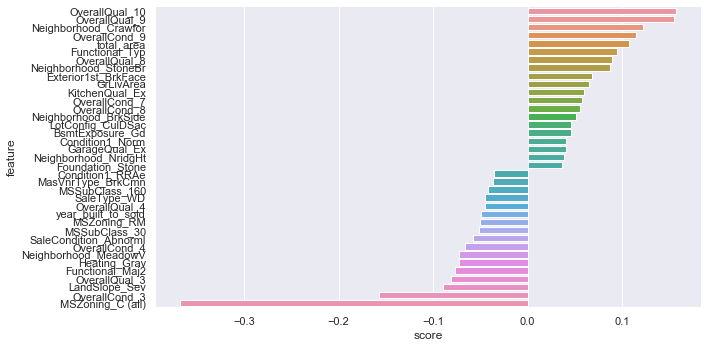

In [163]:
# Plot model weights
fi = plot_fi(final_features, model.coef_)

## Tree-based models

### Random forest

In [55]:
# parameter grid
param_grid = [{
    'n_estimators': [100],
    'max_features': ['log2', 'sqrt'],  # ~300 features
    'max_depth': np.linspace(1, 10, 10)  # ~1300 training samples. Try 1-10
}]


# Random Forest
rf = RandomForestRegressor(bootstrap=True, 
                           random_state=42,
                           n_jobs=-1)

# Grid search
grid_search = GridSearchCV(rf, param_grid,
                           cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=

In [56]:
print_grid_search_result(grid_search, coef=False)

Best hyperparameter set:  {'max_depth': 10.0, 'max_features': 'sqrt', 'n_estimators': 100}
Best RMSE on CV:  0.14552703395244512


In [57]:
# Saving the model
joblib.dump(grid_search.best_estimator_, f'{PATH_DATA}/rf.pkl')

['./datasets/rf.pkl']

#### Feature importance

In [134]:
# Reload the model
model = joblib.load(f'{PATH_DATA}/rf.pkl')

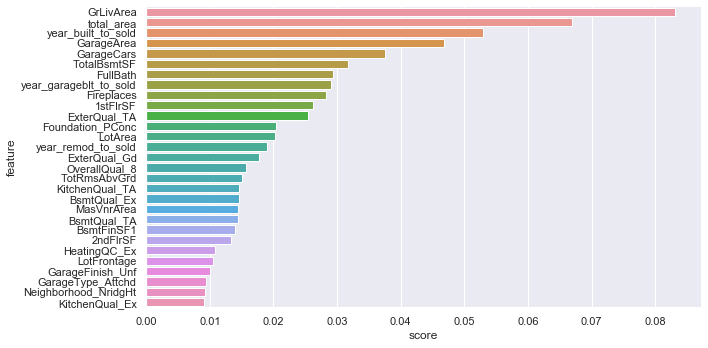

In [135]:
# Built-in feature importance
fi = plot_fi(final_features, model.feature_importances_)

In [136]:
# Permutation importance
perm_fi = eli5.sklearn.PermutationImportance(model).fit(X_train.toarray(), y)

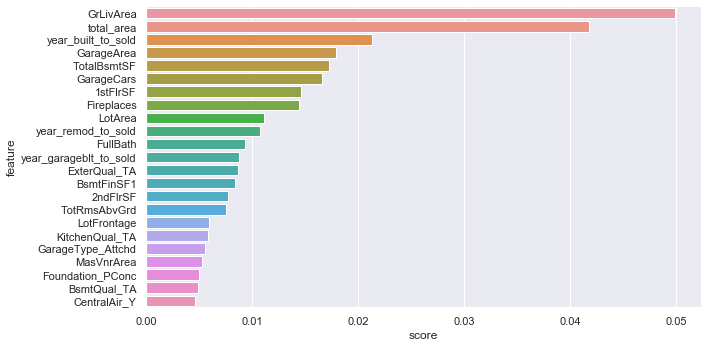

In [137]:
fi = plot_fi(final_features, perm_fi.feature_importances_)

### Gradient boosting

In [60]:
# parameter grid
param_grid = [{
    'learning_rate': [.01, .1],
    'n_estimators': [500],
    'subsample': [.9, 1],
    'max_depth': [3, 5],
    'max_features': [None, 'log2', 'sqrt'],
    'n_iter_no_change': [None]
}]


# Random Forest
gbrt = GradientBoostingRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(gbrt, param_grid,
                           cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weig...
                                                 tol=0.0001,
                                                 val

In [61]:
print_grid_search_result(grid_search, coef=False)

Best hyperparameter set:  {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500, 'n_iter_no_change': None, 'subsample': 1}
Best RMSE on CV:  0.1190336695575482


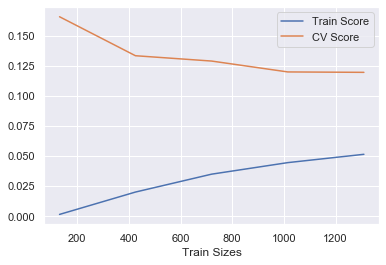

In [62]:
# The learning curve
res = train_and_evaluate(X_train, y, grid_search.best_estimator_)
res.plot.line(x=0)

In [63]:
# Saving the model
joblib.dump(grid_search.best_estimator_, f'{PATH_DATA}/gbrt.pkl')

['./datasets/gbrt.pkl']

#### Feature importance

In [132]:
# Reload the model
model = joblib.load(f'{PATH_DATA}/gbrt.pkl')

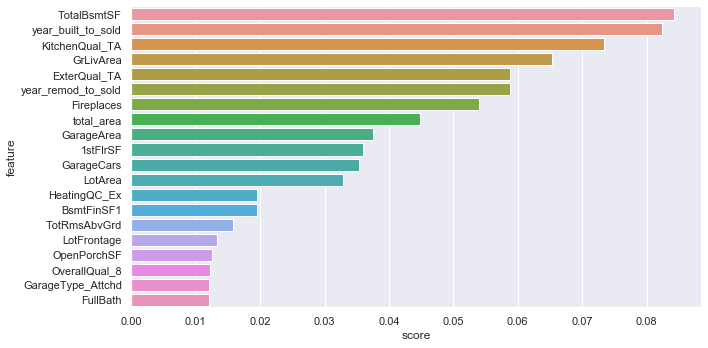

In [133]:
# Built-in feature importance
fi = plot_fi(final_features, model.feature_importances_)

In [123]:
# Permutation importance
perm_fi = eli5.sklearn.PermutationImportance(model).fit(X_train.toarray(), y)

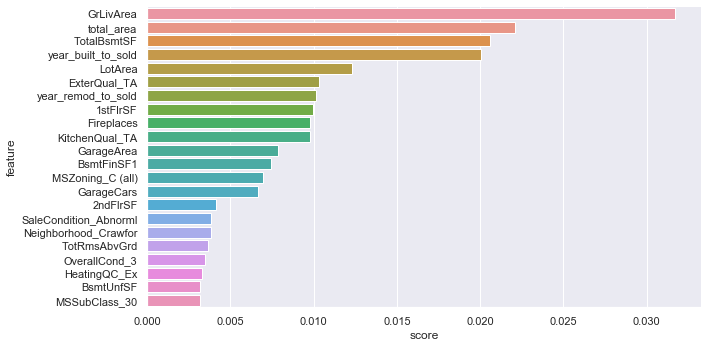

In [131]:
fi = plot_fi(final_features, perm_fi.feature_importances_)

### Restudy some top features

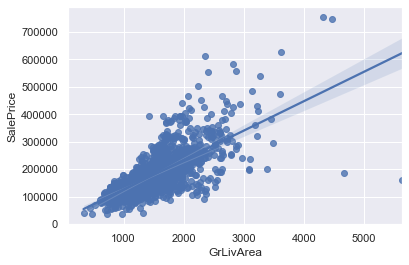

In [66]:
sns.regplot(x = "GrLivArea", y = "SalePrice", data = df_train_raw)

> **Observations:** There are some outliers in some important features. We will remove them back in the data preparation stage.

## Predict

In [70]:
# Load the best linear model that we've dumped to pickle earlier
# Elastic Net in this experiment as it performs the best
elastic_net = joblib.load(f'{PATH_DATA}/elasticnet.pkl')
elastic_net.fit(X_train, y)  # Fit the whole training set

ElasticNet(alpha=0.0003562247890262444, copy_X=True, fit_intercept=True,
           l1_ratio=0.75, max_iter=10000, normalize=False, positive=False,
           precompute=False, random_state=42, selection='random', tol=0.0001,
           warm_start=False)

In [71]:
# Load the best Random Forest model that we've dumped to pickle earlier
rf = joblib.load(f'{PATH_DATA}/rf.pkl')
rf.fit(X_train, y)  # Fit the whole training set

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10.0, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [72]:
# Load the best GBRT model that we've dumped to pickle earlier
gbrt = joblib.load(f'{PATH_DATA}/gbrt.pkl')
gbrt.fit(X_train, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [73]:
y_test = np.expm1(elastic_net.predict(X_test))  
# y was log1p transformed

In [74]:
submission = pd.DataFrame({'Id': df_test_raw['Id'], 'SalePrice': y_test})
submission.to_csv(f'{PATH_DATA}/submission_elasticnet.csv', index=False)

In [75]:
y_test = np.expm1(rf.predict(X_test))  # y was log1p transformed

In [76]:
submission = pd.DataFrame({'Id': df_test_raw['Id'], 'SalePrice': y_test})
submission.to_csv(f'{PATH_DATA}/submission_rf.csv', index=False)

In [77]:
y_test = np.expm1(gbrt.predict(X_test))  # y was log1p transformed

In [78]:
submission = pd.DataFrame({'Id': df_test_raw['Id'], 'SalePrice': y_test})
submission.to_csv(f'{PATH_DATA}/submission_gbrt.csv', index=False)

<hr>

**Submission to Kaggle:**

* Elastic Net: 0.12959
* Random Forest: 0.15651
* GBRT: 0.13658

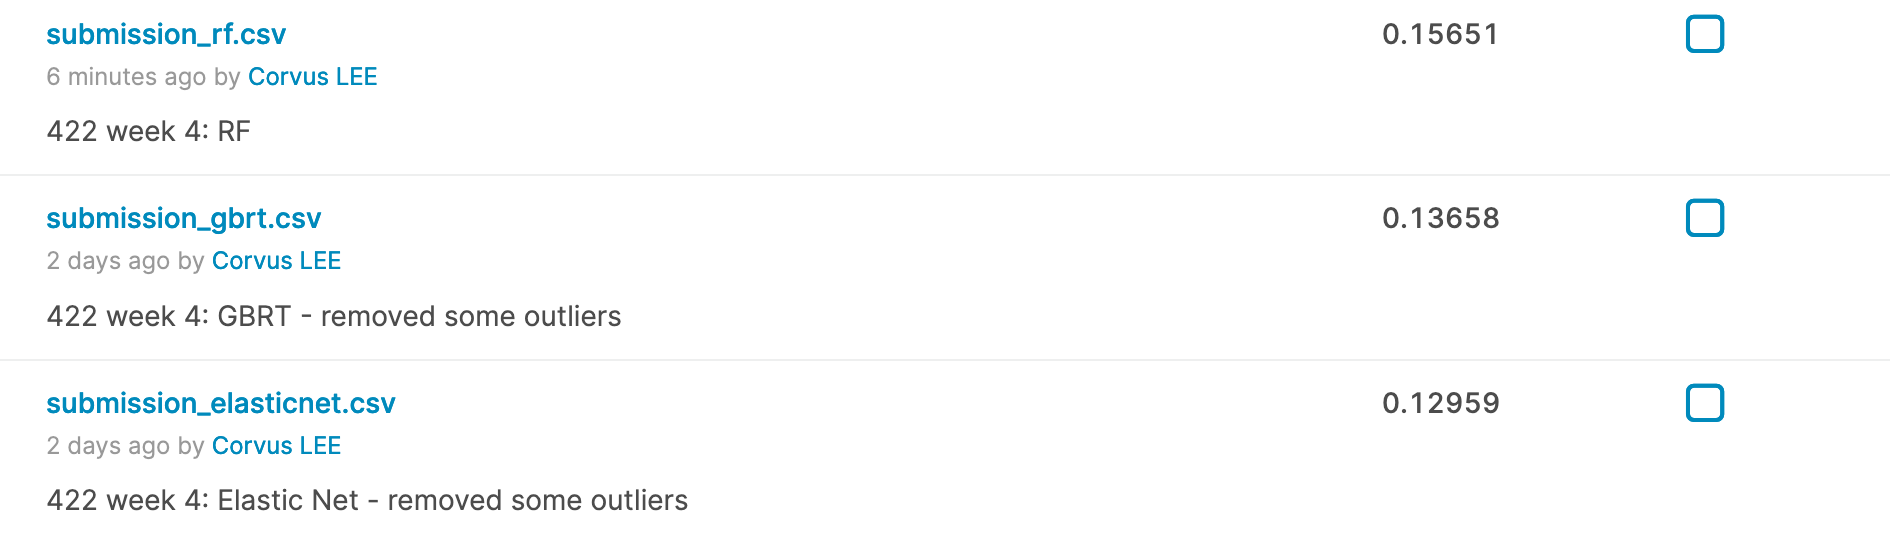

<hr>

# Summary

<hr>

**Summary:** Elastic Net and Gradient Boosted Regression Tree (GBRT) provides similar results in terms of RMSE on test set, but having different 'weights' on the selected features.

* The Elastic Net model captures features effectively which have linear relationship with the sale price, for example `overall quality`, `overall condition` and some area-related features `total area` and `above ground area`. Weights on different `neighborhood` also set a good discussion between machine learning and domain knowledge.
* The GBRT model gives the importance of another list of features. Apart from those area-related, time-related features such as `year from built to sold` and `year from remod to sold` have high score; The model can also capture interesting features such as `number of fireplaces` which worth further study. However, one of the shortcomings of a GBRT's feature importance is that it does not show the direction. For example, `neighbourhood Crawfor` and `MSSubClass 30` play an important role, but it is hard to determine whether the attributes contribute to a higher or lower price.

<hr>